# Постановка задачи

Нужно построить модель, которая сможет по входящим параметрам потока (число Маха $M_{\infty}$ и угол атаки $\alpha$) предсказать распределение поля изоэнтропического числа Маха $M_{is}$ или коэффициента давления $C_p$ по поверхности крыла.
Проверка качества модели будет осуществляться двумя способами:
1. Сравнения предсказанного поля с полем в обучающей выборке (корень из среднего квадратичного отклонения, модуль максимального отклонения и т.д.)
2. По предсказанному полю будут предсказаны коэффициенты Cx, Cy, Cz. Затем их можно сравнить с коэффициентами из обучающей выборки

In [1]:
# библиотеки общего назначения
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# для работы с файлами
import glob

# для проверки суррогатных моделей
import sklearn.metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# для создания моих суррготаных моделей
import MY_SOLVERS as mysol

# для работы с моим интегратором
import my3D_surface_integrator as sint

# для работы с моим крылом
from MY_WINGS import wing1

# для комплексной проверки качества суррогатной модели
import quality_PCA_model as qpca # купец-а

# для сохранения и загрузки суррогатных моделей
import joblib

# для отслеживания прогресса
from tqdm import tqdm

# Чтение данных

In [2]:
regimes = (pd.read_csv("./data/regimes.csv")).drop(['Num'],axis=1)
M_is = pd.DataFrame(columns=np.arange(regimes.shape[0]))
Cp = pd.DataFrame(columns=np.arange(regimes.shape[0]))
XYZ_coords = []

files = glob.glob("data/*_*_*.csv")
files.sort()
for i,path in tqdm(enumerate(files)):
    M_is[i] = pd.read_csv(path)['M_is']
    Cp[i] = pd.read_csv(path)['Cp']
    XYZ_coords.append(pd.read_csv(path, usecols=['Points:0','Points:1','Points:2']))

64it [00:09,  6.55it/s]


In [3]:
total_CxCyCz = pd.DataFrame(columns=['Cx', 'Cy', 'Cz'], data=np.zeros((regimes.shape[0],3)))

files = glob.glob("results/*_*_*")
files.sort()
for i,path in tqdm(enumerate(files)):
    f = open(path, mode='r')

    l = f.readlines()[22]
    sep_words = l.split()

    total_CxCyCz.iloc[i][0] = float(sep_words[-3])
    total_CxCyCz.iloc[i][1] = float(sep_words[-2])
    total_CxCyCz.iloc[i][2] = float(sep_words[-1])    

    f.close()

64it [00:00, 2523.17it/s]


In [4]:
pressure_CxCyCz_lab = pd.read_csv("./my csv/my_CxCyCz_lab", index_col=0)
pressure_CxCyCz_spd = pressure_CxCyCz_lab.copy()

CICLES = pressure_CxCyCz_lab.shape[0]
for i in tqdm(range(CICLES)):
    Cx, Cy, Cz = sint.LabSys2SpdSys_CxCyCz(*pressure_CxCyCz_lab.loc[i], 
                                           AngAt=regimes['alpha'][i], debug=False)
    pressure_CxCyCz_spd.loc[i] = [Cx, Cy, Cz]

100%|██████████| 64/64 [00:00<00:00, 2723.35it/s]


In [5]:
regimes

,M,alpha
0,0.94648,-3.71875
1,0.83867,-2.40625
2,0.81289,5.84375
3,0.84102,3.59375
4,0.89727,2.65625
...,...,...
59,0.85273,4.34375
60,0.82930,0.78125
61,0.85039,-3.34375
62,0.89258,4.90625


In [6]:
M_is

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.632708,0.571669,0.390198,0.427720,0.473098,0.480165,0.413340,0.458278,0.394294,0.485033,...,0.427569,0.530273,0.612114,0.397551,0.542801,0.420202,0.482756,0.601575,0.429612,0.576284
1,0.624054,0.562945,0.389021,0.423578,0.468002,0.473987,0.411813,0.453089,0.393816,0.478279,...,0.425911,0.522455,0.602968,0.395439,0.535451,0.416633,0.476312,0.592400,0.426305,0.568566
2,0.617871,0.556658,0.388920,0.420878,0.464434,0.469505,0.411405,0.449446,0.394388,0.473356,...,0.425394,0.516773,0.596469,0.394538,0.530111,0.414456,0.471624,0.585883,0.424350,0.562979
3,0.609374,0.548063,0.389335,0.417898,0.460239,0.463948,0.411384,0.445164,0.395637,0.467081,...,0.425213,0.509213,0.587430,0.393848,0.523114,0.412182,0.465730,0.576810,0.422365,0.555541
4,0.602034,0.540601,0.390939,0.416171,0.457225,0.459511,0.412605,0.442067,0.398039,0.461890,...,0.426271,0.502732,0.579558,0.394358,0.517188,0.411163,0.460938,0.568902,0.421610,0.549187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79020,1.152570,0.796430,0.933590,0.834577,0.908835,0.817724,1.040706,0.829551,0.980441,0.790649,...,1.180183,0.794666,0.871458,0.945453,0.840624,0.919984,0.804216,0.809692,1.018564,0.905449
79021,1.152351,0.796666,0.934371,0.835167,0.911050,0.817861,1.041747,0.829660,0.980780,0.790822,...,1.180820,0.794888,0.870899,0.946886,0.840791,0.921418,0.804378,0.809885,1.019867,0.906696
79022,1.152270,0.796900,0.935178,0.835720,0.913267,0.818001,1.042858,0.829770,0.981067,0.791000,...,1.181501,0.795109,0.870687,0.947894,0.840952,0.922773,0.804543,0.810168,1.021180,0.907930
79023,1.152262,0.797132,0.936057,0.836247,0.915450,0.818148,1.044035,0.829896,0.981352,0.791185,...,1.182336,0.795329,0.870782,0.948509,0.841109,0.924098,0.804714,0.810536,1.022542,0.909135


In [7]:
Cp

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.573607,0.548555,0.842745,0.809599,0.791979,0.723414,0.867583,0.775789,0.858125,0.682685,...,0.888817,0.612599,0.515108,0.839943,0.658014,0.833058,0.703074,0.506499,0.855921,0.639845
1,0.588931,0.565368,0.844624,0.816281,0.800149,0.734142,0.869889,0.784361,0.858887,0.694975,...,0.891234,0.627341,0.532501,0.843287,0.671049,0.838662,0.714525,0.524300,0.860930,0.653391
2,0.599824,0.577389,0.844777,0.820588,0.805816,0.741853,0.870488,0.790320,0.858008,0.703847,...,0.891961,0.637962,0.544781,0.844694,0.680448,0.842041,0.722781,0.536857,0.863853,0.663133
3,0.614753,0.593759,0.844128,0.825330,0.812452,0.751369,0.870513,0.797296,0.856092,0.715104,...,0.892207,0.652031,0.561804,0.845776,0.692717,0.845565,0.733111,0.554279,0.866823,0.676061
4,0.627571,0.607844,0.841594,0.828043,0.817170,0.758893,0.868668,0.802288,0.852379,0.724322,...,0.890649,0.663978,0.576518,0.844967,0.703022,0.847120,0.741427,0.569340,0.867926,0.687025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79020,-0.350037,0.088484,-0.259684,0.013429,-0.022166,0.053306,-0.310836,0.056797,-0.297100,0.053260,...,-0.440722,0.068765,0.000045,-0.260829,0.083772,-0.136683,0.053235,0.083836,-0.238053,0.024108
79021,-0.349690,0.087989,-0.261337,0.012198,-0.026402,0.053021,-0.312754,0.056574,-0.297780,0.052884,...,-0.441733,0.068292,0.001157,-0.263809,0.083443,-0.139571,0.052892,0.083438,-0.240445,0.021775
79022,-0.349562,0.087497,-0.263045,0.011046,-0.030640,0.052730,-0.314802,0.056349,-0.298357,0.052499,...,-0.442812,0.067821,0.001581,-0.265902,0.083124,-0.142297,0.052542,0.082854,-0.242854,0.019468
79023,-0.349549,0.087011,-0.264904,0.009947,-0.034811,0.052424,-0.316969,0.056092,-0.298931,0.052098,...,-0.444135,0.067351,0.001390,-0.267181,0.082815,-0.144963,0.052177,0.082095,-0.245351,0.017216


In [8]:
XYZ_coords[0]

,Points:0,Points:1,Points:2
0,4.531483,-0.045957,0.094869
1,4.531380,-0.045805,0.094880
2,4.531278,-0.045653,0.094890
3,4.531182,-0.045496,0.094901
4,4.531093,-0.045335,0.094913
...,...,...,...
79020,5.031160,-0.001567,0.613544
79021,5.028323,-0.001948,0.607334
79022,5.025487,-0.002333,0.601124
79023,5.022651,-0.002727,0.594914


In [9]:
total_CxCyCz

,Cx,Cy,Cz
0,0.083398,-0.298906,0.149321
1,0.024050,-0.136088,0.131233
2,0.080494,0.784640,0.152704
3,0.046048,0.701913,0.134848
4,0.043631,0.510899,0.132618
...,...,...,...
59,0.060453,0.723859,0.138587
60,0.021536,0.316106,0.123653
61,0.035199,-0.238177,0.135942
62,0.078851,0.708251,0.144728


In [10]:
pressure_CxCyCz_lab

,Cx,Cy,Cz
0,0.042907,-0.254386,0.019553
1,0.004022,-0.118611,0.022502
2,-0.010752,0.648169,-0.032265
3,-0.009025,0.592861,-0.027000
4,0.006403,0.433695,-0.021124
...,...,...,...
59,-0.006143,0.610567,-0.030135
60,0.002876,0.264651,-0.010445
61,0.006877,-0.204706,0.029541
62,0.004897,0.595434,-0.034673


In [11]:
pressure_CxCyCz_spd

,Cx,Cy,Cz
0,0.059316,-0.251068,0.019553
1,0.008998,-0.118338,0.022502
2,0.055297,0.645895,-0.032265
3,0.028154,0.592261,-0.027000
4,0.026495,0.432933,-0.021124
...,...,...,...
59,0.040119,0.609278,-0.030135
60,0.006485,0.264588,-0.010445
61,0.018805,-0.203956,0.029541
62,0.055804,0.592834,-0.034673


# Создание крыла

In [12]:
wing = wing1()

print(wing.n_parts)
print(wing.dims_zones)
print([len(wing.zones_inds[i]) for i in range(wing.n_parts)])

10
[(49, 17), (256, 49), (96, 17), (256, 48), (256, 48), (49, 16), (256, 49), (96, 16), (256, 48), (256, 48)]
[833, 12544, 1632, 12288, 12288, 784, 12544, 1536, 12288, 12288]


# Выберем лучшую суррогатную модель

In [30]:
# ячейка для просмотра документации
mysol.DISTRIBUTION_PREDICTION()

DISTRIBUTION_PREDICTION()

In [36]:
kw_args_for_sm = {
    'print_global' : False,
}

param_grid = {
#     "surrogate_model_name" : ["LS", "KRG", "RBF"],
    "surrogate_model_name" : ["KRG"],
    "Npc" : range(1,14),
    'n_parts' : [1, 5, 10],
    "kw_args" : [kw_args_for_sm],
    "hello_words" : [False]
}

In [37]:
%%time
GS_solver = GridSearchCV(mysol.DISTRIBUTION_PREDICTION(), param_grid=param_grid, cv=3, 
                         scoring='neg_root_mean_squared_error', n_jobs=-1)
GS_solver.fit(regimes, Cp.T)

CPU times: user 2.88 s, sys: 274 ms, total: 3.16 s
Wall time: 1min 20s


GridSearchCV(cv=3, estimator=DISTRIBUTION_PREDICTION(), n_jobs=-1,
             param_grid={'Npc': range(1, 14), 'hello_words': [False],
                         'kw_args': [{'print_global': False}],
                         'n_parts': [1, 5, 10],
                         'surrogate_model_name': ['KRG']},
             scoring='neg_root_mean_squared_error')

In [40]:
# лучшей оказалась комбинция
print("GS_solver.best_params_['Npc'] =", GS_solver.best_params_['Npc'])
print("GS_solver.best_params_['sm_name'] =", GS_solver.best_params_['surrogate_model_name'])
print("GS_solver.best_params_['n_parts'] =", GS_solver.best_params_['n_parts'])
# if GS_solver.best_params_['parts'] == None :
#     print("GS_solver.best_params_['parts'] == None")
# else:
#     print("GS_solver.best_params_['parts'] != None")

GS_solver.best_params_['Npc'] = 7
GS_solver.best_params_['sm_name'] = KRG
GS_solver.best_params_['n_parts'] = 1


In [41]:
# и её результат по метрике neg_root_mean_squared_error
GS_solver.best_score_

-0.07195685024657962

In [42]:
[GS_solver.cv_results_['params'][i]['Npc'] for i in range(6)]

[1, 1, 1, 2, 2, 2]

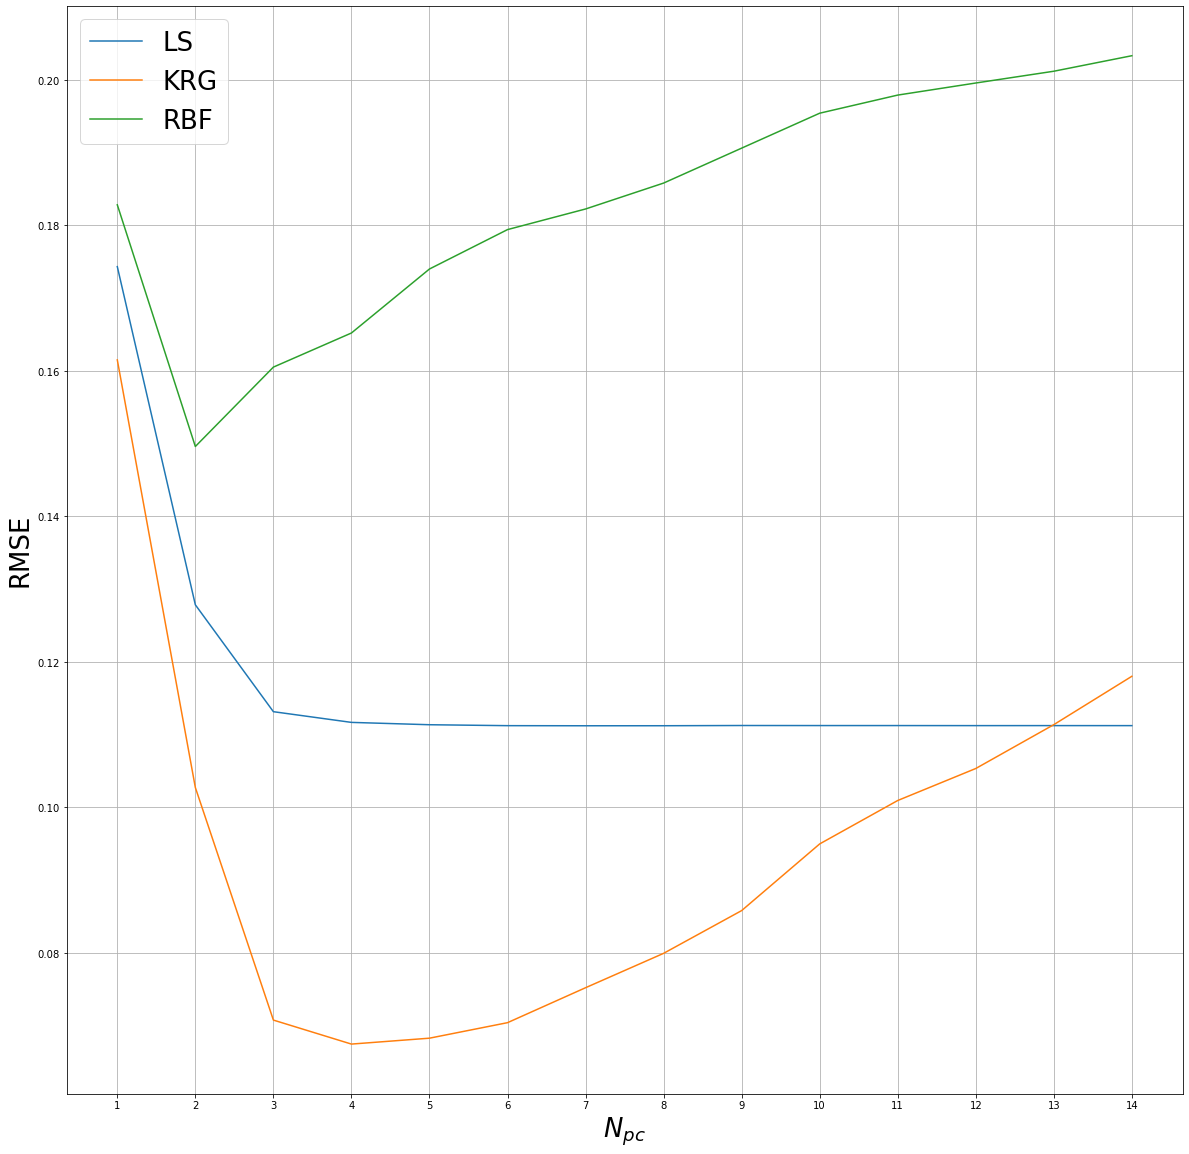

In [19]:
plt.figure(figsize=(20,20), facecolor='white')

npc = range(1,15) # по максимальному числу главных компонент
for i in range(3): # по количеству используемых суррогатных моделей
    y = -1*GS_solver.cv_results_['mean_test_score'][i::3]
    label = GS_solver.cv_results_['params'][i]['surrogate_model_name']
    plt.plot(npc, y, label=label)

plt.xticks(npc)
plt.legend(fontsize=26)
plt.grid(True)
plt.xlabel("$N_{pc}$", size=26)
plt.ylabel("RMSE", size=26)
plt.show()

Лучшая модель Кригинг на 4 компонентах (при предварительной разбивке поля)

# Посчитаем ошибку лучшей модели

In [34]:
# Выделим тестовые случаи, а остальные оставим для обучения

# Способ 1 
#(здесь можно явно указать, какие прециденты мы хотим оставить на тест)
# number_of_test_regime = [63]

# train_Cp = Cp.drop(number_of_test_regime, axis=1)
# test_Cp = Cp[number_of_test_regime]

# train_regimes = regimes.drop(number_of_test_regime,axis=0)
# test_regimes = regimes.iloc[number_of_test_regime]
# test_regimes_index = test_regimes.index.to_numpy()


# Способ 2 
#(здесь можно легко указать, сколько прецидентом мы хотим оставить на тест)[сейчас работает этот способ]
train_regimes, test_regimes, train_Cp, test_Cp = train_test_split(regimes, Cp.T,test_size=56/64, random_state=42)
train_Cp = train_Cp.T.copy()
test_Cp = test_Cp.T.copy()


# выцепим нужную информацию для тестирования
test_regimes_index = test_regimes.index.to_numpy()
set_origin_cx=pressure_CxCyCz_spd.loc[test_regimes_index]['Cx'].to_numpy()
set_origin_cy=pressure_CxCyCz_spd.loc[test_regimes_index]['Cy'].to_numpy()
test_regimes_index

array([52, 58,  0, 44,  5, 36, 16, 12, 25, 61, 56,  9, 40, 13, 34, 50,  3,
       17, 49,  8,  6, 33,  4, 47, 19, 54, 41, 55, 31, 30, 59, 60, 15, 27,
       26, 24, 46, 11, 32, 57, 45, 37, 29, 43, 48,  1, 21,  2, 62, 39, 35,
       23, 53, 10, 22, 18])

In [35]:
%%time
best_model = mysol.DISTRIBUTION_PREDICTION(surrogate_model_name='KRG', 
                                           Npc=7, 
                                           n_parts=1)
best_model.fit(regimes=train_regimes, target_T=train_Cp.T)

CPU times: user 727 ms, sys: 32.1 ms, total: 759 ms
Wall time: 483 ms


In [36]:
set_predicted_cp = best_model.predict(test_regimes)
set_predicted_cp

,0,1,2,3,4,5,6,7,8,9,...,79015,79016,79017,79018,79019,79020,79021,79022,79023,79024
0,0.795421,0.801469,0.805087,0.809329,0.811676,0.812838,0.812384,0.810297,0.806334,0.800206,...,-0.129495,-0.131506,-0.133431,-0.135292,-0.137120,-0.138902,-0.140570,-0.142306,-0.144150,-0.145925
1,0.794295,0.800439,0.804144,0.808497,0.810958,0.812246,0.811928,0.809993,0.806195,0.800252,...,-0.125770,-0.127738,-0.129617,-0.131432,-0.133215,-0.134949,-0.136568,-0.138251,-0.140039,-0.141754
2,0.795490,0.801534,0.805150,0.809388,0.811733,0.812892,0.812435,0.810345,0.806378,0.800249,...,-0.131271,-0.133294,-0.135230,-0.137103,-0.138943,-0.140736,-0.142416,-0.144164,-0.146020,-0.147806
3,0.818932,0.823381,0.825728,0.828083,0.828507,0.827425,0.824533,0.819664,0.812610,0.802973,...,-0.184644,-0.186840,-0.188919,-0.190952,-0.193066,-0.195356,-0.197805,-0.200642,-0.203921,-0.207426
4,0.782865,0.789600,0.793786,0.798781,0.801849,0.803823,0.804258,0.803164,0.800270,0.795321,...,-0.068831,-0.070606,-0.072289,-0.073909,-0.075503,-0.077047,-0.078502,-0.080009,-0.081589,-0.083106
5,0.793629,0.799771,0.803466,0.807810,0.810256,0.811530,0.811198,0.809247,0.805430,0.799465,...,-0.121222,-0.123202,-0.125093,-0.126921,-0.128718,-0.130466,-0.132106,-0.133811,-0.135620,-0.137359
6,0.812232,0.818004,0.821440,0.825327,0.827318,0.828063,0.827112,0.824414,0.819768,0.812845,...,-0.148740,-0.151337,-0.153821,-0.156202,-0.158500,-0.160708,-0.162746,-0.164824,-0.166991,-0.169040
7,0.783034,0.789654,0.793735,0.798640,0.801646,0.803553,0.803908,0.802737,0.799779,0.794788,...,-0.120995,-0.123090,-0.125108,-0.127070,-0.129005,-0.130897,-0.132684,-0.134533,-0.136480,-0.138357
8,0.829547,0.835597,0.839468,0.843609,0.845842,0.846781,0.846031,0.843522,0.839019,0.832170,...,-0.124243,-0.126705,-0.129067,-0.131335,-0.133520,-0.135586,-0.137445,-0.139308,-0.141247,-0.143045
9,0.795767,0.801798,0.805403,0.809626,0.811956,0.813098,0.812623,0.810511,0.806521,0.800365,...,-0.130960,-0.132977,-0.134908,-0.136774,-0.138609,-0.140396,-0.142069,-0.143811,-0.145661,-0.147441


In [37]:
%%time
errs = qpca.seria_of_prediction_quality(set_predicted_cp=set_predicted_cp, 
                                        set_origin_cp=test_Cp.T,
                                        set_origin_cx=set_origin_cx,
                                        set_origin_cy=set_origin_cy,
                                        set_regime=test_regimes.to_numpy(),
                                        XYZ_coords=[XYZ_coords[i] for i in test_regimes_index],
                                        wing=wing,
                                        need_print_total=True, 
                                        round_digit=6,
                                        debug=False,
                                        progres_by_samples=True);

seria_of_prediction_quality : sample 0/56
	calculating predicted_cx, predicted_cy
seria_of_prediction_quality : sample 1/56
	calculating predicted_cx, predicted_cy
seria_of_prediction_quality : sample 2/56
	calculating predicted_cx, predicted_cy
seria_of_prediction_quality : sample 3/56
	calculating predicted_cx, predicted_cy
seria_of_prediction_quality : sample 4/56
	calculating predicted_cx, predicted_cy
seria_of_prediction_quality : sample 5/56
	calculating predicted_cx, predicted_cy
seria_of_prediction_quality : sample 6/56
	calculating predicted_cx, predicted_cy
seria_of_prediction_quality : sample 7/56
	calculating predicted_cx, predicted_cy
seria_of_prediction_quality : sample 8/56
	calculating predicted_cx, predicted_cy
seria_of_prediction_quality : sample 9/56
	calculating predicted_cx, predicted_cy
seria_of_prediction_quality : sample 10/56
	calculating predicted_cx, predicted_cy
seria_of_prediction_quality : sample 11/56
	calculating predicted_cx, predicted_cy
seria_of_predi

In [20]:
rmse_cp, mae_cp, ae_cx, ae_cy, re_cx, re_cy, rmse_cx, rmse_cy = errs

А теперь попробуем не разбивать поле на заранее определённые части

In [25]:
kw_args_for_sm = {
    'print_global' : False,
}

param_grid = {
    "surrogate_model_name" : ["KRG"],
    "Npc" : range(1,20),
    "n_parts" : [wing.n_parts],
    "parts" : [wing.zones_inds, None],
    "kw_args" : [kw_args_for_sm],
    "hello_words" : [False]
}

In [26]:
%%time
GS_solver = GridSearchCV(mysol.DISTRIBUTION_PREDICTION(), param_grid=param_grid, cv=3, 
                         scoring='neg_root_mean_squared_error', n_jobs=-1)
GS_solver.fit(regimes, Cp.T)

CPU times: user 10.9 s, sys: 500 ms, total: 11.4 s
Wall time: 58.4 s


GridSearchCV(cv=3, estimator=DISTRIBUTION_PREDICTION(), n_jobs=-1,
             param_grid={'Npc': range(1, 20), 'hello_words': [False],
                         'kw_args': [{'print_global': False}], 'n_parts': [10],
                         'parts': [[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,...
       40350, 40351, 40352, 40353, 40354, 40355, 40356, 40357, 40358,
       40359, 40360, 40361, 40362, 40363, 40364, 40365, 40366, 40367,
       40368]),
                                    array([40369, 40370, 40371, ..., 52910, 52911, 52912]),
                                    array([52913, 52914, 52915, ..., 54446, 54447, 54448]),
                                    array([54449, 54450, 54451, ..., 66734

In [27]:
# лучшей оказалась комбинция
print("GS_solver.best_params_['Npc'] =", GS_solver.best_params_['Npc'])
print("GS_solver.best_params_['sm_name'] =", GS_solver.best_params_['surrogate_model_name'])
if GS_solver.best_params_['parts'] == None :
    print("GS_solver.best_params_['parts'] == None")
else:
    print("GS_solver.best_params_['parts'] != None")

GS_solver.best_params_['Npc'] = 4
GS_solver.best_params_['sm_name'] = KRG
GS_solver.best_params_['parts'] == None


In [28]:
# и её результат по метрике neg_root_mean_squared_error
GS_solver.best_score_

-0.06514213339642987